In [84]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm

In [85]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 12
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [86]:
# MNIST data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist.data
y = mnist.target.astype(int)

In [87]:
# Train/Pool/Test split
# Train = 20 (2 per class), Test = 10000 (1000 per class), Pool = Rest

import numpy as np
np.random.seed(42)
from sklearn.model_selection import train_test_split
X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=100, stratify=y)
X_pool, X_test, y_pool, y_test = train_test_split(X_pool, y_pool, test_size=10000, stratify=y_pool)

In [88]:
# Print shapes
print(X_train.shape)
print(X_pool.shape)
print(X_test.shape)

(100, 784)
(59900, 784)
(10000, 784)


In [89]:
# Train a Logistic Regression model on the training data
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


LogisticRegression()

In [90]:
# Evaluate on test data
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7581


/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Main loop
1. Train model on training data
2. Predict on pool data
3. Find the most uncertain predictions as per the uncertainty measure
4. Label those instances
5. Add them to the training data
6. Remove them from the pool data
7. Repeat until budget is exhausted
    

In [91]:
def al_loop(clf, n_steps, X_pool, y_pool, X_test, y_test, query_strategy, step_size=1):
    X_train_loop = X_train.copy().values
    y_train_loop = y_train.copy().values
    # Initialize lists to store performance metrics
    test_accs = []
    pool_accs = []
    pool_sizes = []
    
    # Initialize pool and test set and convert to numpy arrays
    X_pool = X_pool.copy().values
    y_pool = y_pool.copy().values
    X_test = X_test.copy().values
    y_test = y_test.copy().values

    
    # Loop
    for step in tqdm(range(n_steps)):
        # Train classifier on current training set
        clf.fit(X_train_loop, y_train_loop)
        
        # Evaluate on test set
        y_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        test_accs.append(test_acc)
        
        # Evaluate on pool set
        y_pred = clf.predict(X_pool)
        pool_acc = accuracy_score(y_pool, y_pred)
        pool_accs.append(pool_acc)
        
        # Append pool size
        pool_sizes.append(len(X_pool))
        
        # Query new instances from pool
        idx = query_strategy(clf, X_pool, y_pool, step_size)
        
        # Add queried instances to training set
        X_train_loop = np.concatenate((X_train_loop, X_pool[idx]), axis=0)
        y_train_loop = np.concatenate((y_train_loop, y_pool[idx]), axis=0)
        
        # Remove queried instances from pool
        X_pool = np.delete(X_pool, idx, axis=0)
        y_pool = np.delete(y_pool, idx, axis=0)
        
    return test_accs, pool_accs, pool_sizes

In [92]:
def random_sampling(clf, X_pool, y_pool, step_size=1):
    idx = np.random.choice(len(X_pool), step_size, replace=False)
    return idx

In [93]:
# Evaluate random sampling 10 times using different random seeds
test_accs_random = []
pool_accs_random = []
pool_sizes_random = []
for i in tqdm(range(8)):
    test_accs, pool_accs, pool_sizes = al_loop(clf, 50, X_pool, y_pool, X_test, y_test, random_sampling)
    test_accs_random.append(test_accs)
    pool_accs_random.append(pool_accs)
    pool_sizes_random.append(pool_sizes)


100%|██████████| 8/8 [01:21<00:00, 10.20s/it]


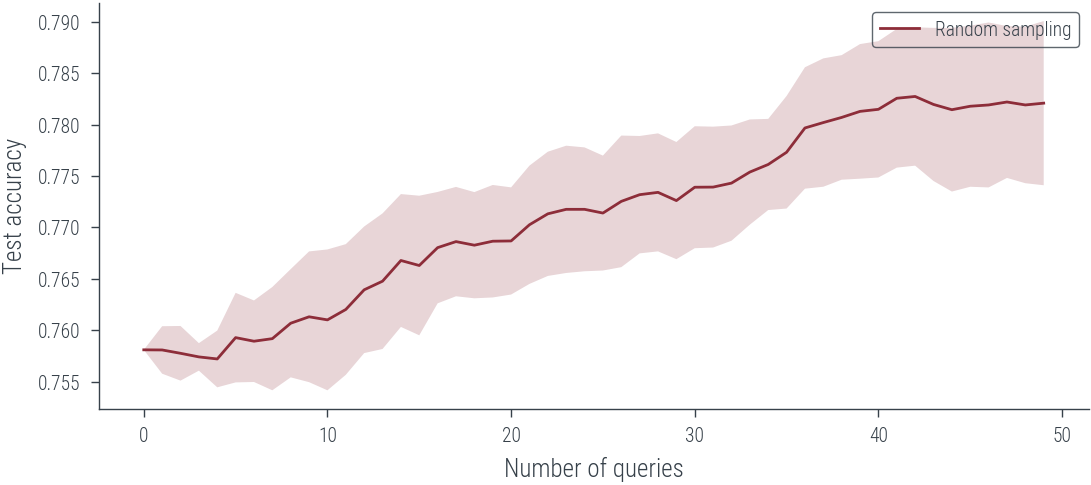

In [94]:
# Plot mean and standard deviation of test accuracy for random sampling
random_mean = np.mean(test_accs_random, axis=0)
random_std = np.std(test_accs_random, axis=0)
plt.plot(random_mean, label='Random sampling')
plt.fill_between(range(len(random_mean)), random_mean-random_std, random_mean+random_std, alpha=0.2)
plt.xlabel('Number of queries')
plt.ylabel('Test accuracy')
plt.legend()

In [95]:
# Now let's implement uncertainty sampling using the entropy of the predicted probabilities
def entropy_sampling(clf, X_pool, y_pool, step_size=1):
    # Predict probabilities
    y_prob = clf.predict_proba(X_pool)
    # Compute entropy
    entropy = -np.sum(y_prob*np.log(y_prob), axis=1)
    # Select samples with highest entropy
    idx = np.argsort(entropy)[-step_size:]
    return idx

In [96]:
# Evaluate uncertainty sampling AL loop
test_accs_entropy, pool_accs_entropy, pool_sizes_entropy = al_loop(clf, 50, X_pool, y_pool, X_test, y_test, entropy_sampling, step_size=1)

 82%|████████▏ | 41/50 [00:10<00:02,  3.47it/s]/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 50/50 [00:12<00:00,  3.87it/s]


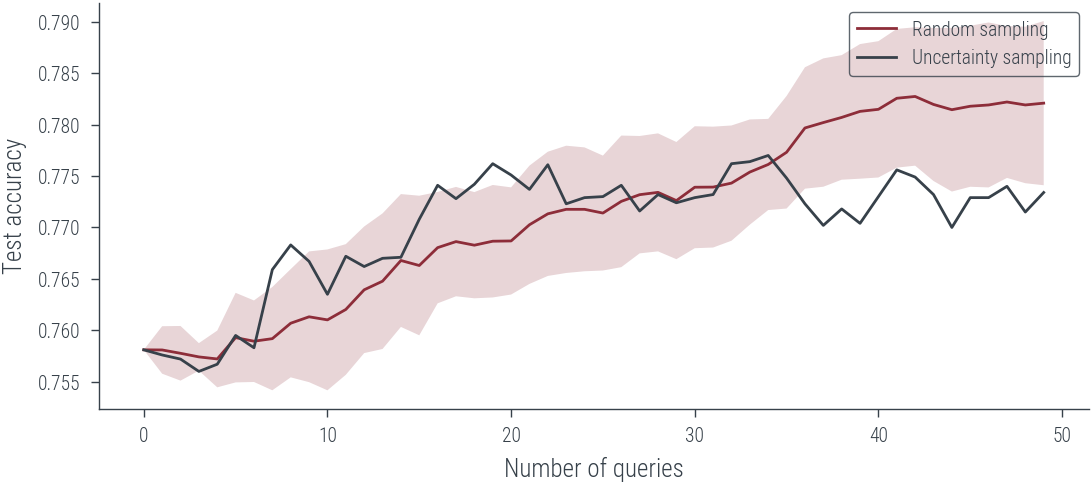

In [97]:
# Plot test accuracy for random and uncertainty sampling
plt.plot(random_mean, label='Random sampling')
plt.plot(test_accs_entropy, label='Uncertainty sampling')
plt.fill_between(range(len(random_mean)), random_mean-random_std, random_mean+random_std, alpha=0.2)
plt.xlabel('Number of queries')
plt.ylabel('Test accuracy')
plt.legend()


In [98]:
def least_confidence_sampling(clf, X_pool, y_pool, step_size=1):
    # Predict probabilities
    y_prob = clf.predict_proba(X_pool)
    # Compute least confidence
    least_confidence = 1-np.max(y_prob, axis=1)
    # Select samples with highest least confidence
    idx = np.argsort(least_confidence)[-step_size:]
    return idx

In [106]:
# Evaluate least confidence sampling AL loop
test_accs_lc, pool_accs_lc, pool_sizes_lc = al_loop(clf, 50, X_pool, y_pool, X_test, y_test, least_confidence_sampling, step_size=2)

 46%|████▌     | 23/50 [00:07<00:08,  3.31it/s]/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|█████     | 25/50 [00:07<00:07,  3.29it/s]/home/nipun.batra/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation f

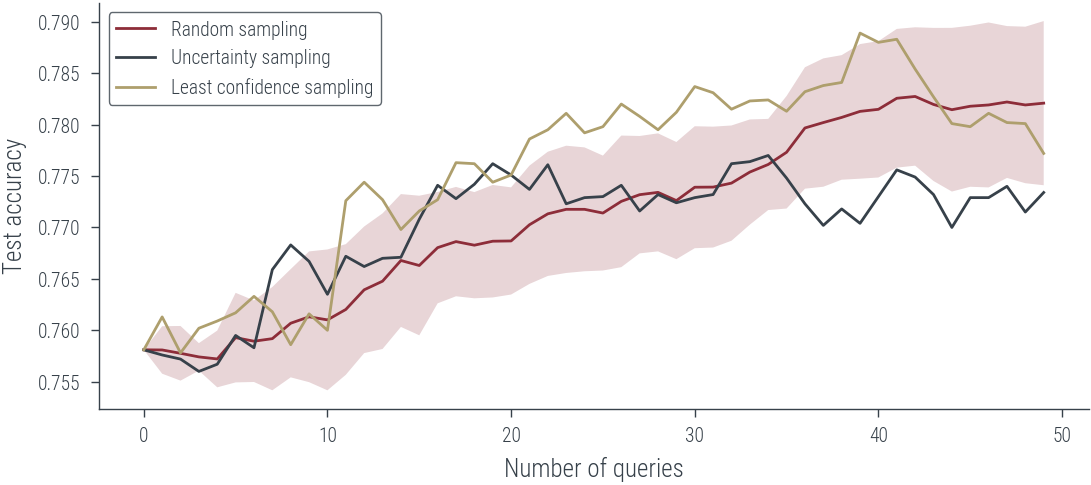

In [100]:
# Plot test accuracy for random and uncertainty sampling
plt.plot(random_mean, label='Random sampling')
plt.plot(test_accs_entropy, label='Uncertainty sampling')
plt.plot(test_accs_lc, label='Least confidence sampling')
plt.fill_between(range(len(random_mean)), random_mean-random_std, random_mean+random_std, alpha=0.2)
plt.xlabel('Number of queries')
plt.ylabel('Test accuracy')
plt.legend()


In [101]:
# Margin sampling (difference between most and second most likely class)
def margin_sampling(clf, X_pool, y_pool, step_size=1):
    # Predict probabilities
    y_prob = clf.predict_proba(X_pool)
    # Sorted probabilities
    y_prob_sorted = np.sort(y_prob, axis=1)
    # Compute margin
    margin = y_prob_sorted[:, -1] - y_prob_sorted[:, -2]
    # Select samples with highest margin
    idx = np.argsort(margin)[-step_size:]
    return idx

In [104]:
# Evaluate margin sampling AL loop
test_accs_margin, pool_accs_margin, pool_sizes_margin = al_loop(clf, 50, X_pool, y_pool, X_test, y_test, margin_sampling, step_size=2)

100%|██████████| 50/50 [00:15<00:00,  3.29it/s]


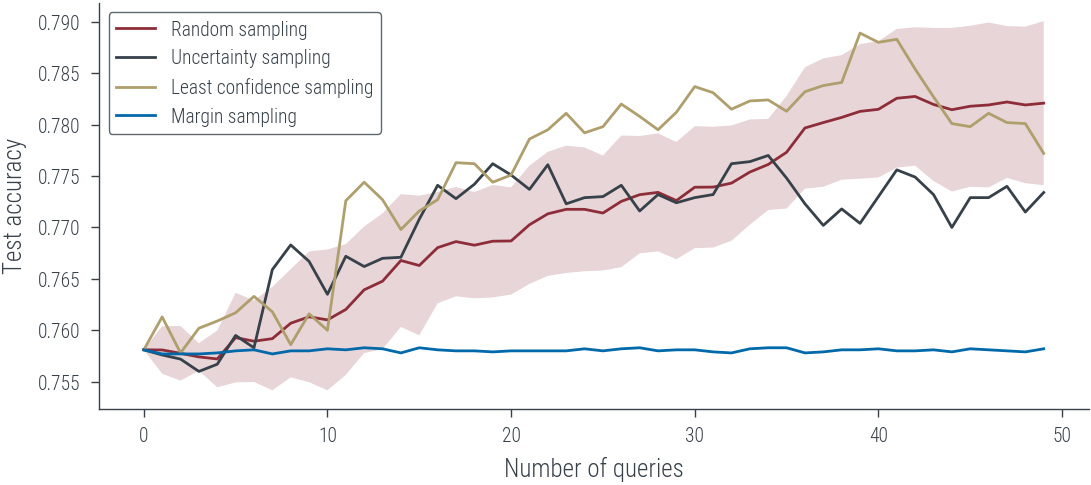

In [105]:
# Plot test accuracy for random and uncertainty sampling
plt.plot(random_mean, label='Random sampling')
plt.plot(test_accs_entropy, label='Uncertainty sampling')
plt.plot(test_accs_lc, label='Least confidence sampling')
plt.plot(test_accs_margin, label='Margin sampling')
plt.fill_between(range(len(random_mean)), random_mean-random_std, random_mean+random_std, alpha=0.2)
plt.xlabel('Number of queries')
plt.ylabel('Test accuracy')
plt.legend()
